# Assignment 2

Melon Musk, the owner of SooperMall has asked a data scientist to help him develop a predictive model for managing his revenue.
The data collected for 1000 customers is in the excel sheet attached.
    
    1) Fit a regression model with amount spent as target, and identify the relevant explanatory variables.
    2) Which age groups spends the most on purchases? 
    3) How much additional spend is an extra catalog expected to generate?
    4) What is the impact of no of children on amount spent. Does this make sense?Explain.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [3]:
df = pd.read_excel("Assignment 02 - SooperMall Catalog Marketing.xlsx", sheet_name='Data')
df.head(5)

,Person,Age,Gender,Own Home,Married,Close,Salary,Children,Catalogs,Amount Spent
0,1,1,0,0,0,1,16400,1,12,217.691
1,2,2,0,1,1,0,108100,3,18,2632.462
2,3,2,1,1,1,1,97300,1,12,3047.563
3,4,3,1,1,1,1,26800,0,12,434.606
4,5,1,1,0,0,1,11200,0,6,105.624


In [106]:
df.groupby('Age').agg({'Amount Spent' : ['min', 'max', 'sum', 'mean', 'count']})

Amount Spent                                         
             min       max         sum         mean count
Age                                                      
1         37.807  3688.445  160325.145   558.624199   287
2        156.772  5877.734  762856.131  1501.685297   508
3         64.839  6217.343  293586.587  1432.129693   205

In [114]:
#sns.scatterplot(x=df["Salary"], y=df["Amount Spent"], hue=df["Children"])
#plt.show()

In [115]:
#sns.scatterplot(x=df["Catalogs"], y=df["Amount Spent"], hue=df["Catalogs"])
#plt.show()

In [116]:
#sns.scatterplot(x=df["Children"], y=df["Amount Spent"])
#plt.show()

In [7]:
df[["Amount Spent", "Salary", "Children", "Catalogs"]].corr()

,Amount Spent,Salary,Children,Catalogs
Amount Spent,1.000000,0.699598,-0.222302,0.472644
Salary,0.699598,1.000000,0.049663,0.183551
Children,-0.222302,0.049663,1.000000,-0.113455
Catalogs,0.472644,0.183551,-0.113455,1.000000


In [117]:
# create box plot for other variables, to understand data
#cat_var_list = ["Age", "Gender", "Own Home", "Married", "Close"]
#fig, axes = plt.subplots(len(cat_var_list), 1, figsize=(12,20), sharex=False, sharey=True)

#sns.set_theme(style="whitegrid")

#for i, ax in enumerate(axes.ravel()):
#    y_var = 'Amount Spent'
#    x_var = cat_var_list[i]
#    sns.violinplot(x=x_var, y=y_var, data=df, ax=ax)
#plt.show()

In [37]:
# add dummy variables in data for categorical variables
df_dummy = pd.get_dummies(df.drop('Person', axis=1), prefix="Age_gp", 
                           columns=["Age"], 
                           drop_first=False)
df_dummy.head()

,Gender,Own Home,Married,Close,Salary,Children,Catalogs,Amount Spent,Age_gp_1,Age_gp_2,Age_gp_3
0,0,0,0,1,16400,1,12,217.691,1,0,0
1,0,1,1,0,108100,3,18,2632.462,0,1,0
2,1,1,1,1,97300,1,12,3047.563,0,1,0
3,1,1,1,1,26800,0,12,434.606,0,0,1
4,1,0,0,1,11200,0,6,105.624,1,0,0


In [18]:
def fit_lin_reg_with_intercept(X, Y):
    X = sm.add_constant(X) # adding a constan
    reg_model = sm.OLS(Y,X).fit()
    return reg_model

In [38]:
x_var = ["Gender", "Own Home", "Married", "Close", "Salary", "Children", "Catalogs", "Age_gp_2", "Age_gp_3"]
reg_model = fit_lin_reg_with_intercept(X=df_dummy[x_var], Y=df_dummy[["Amount Spent"]])
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:           Amount Spent   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     278.5
Date:                Sun, 15 May 2022   Prob (F-statistic):          4.26e-264
Time:                        11:59:29   Log-Likelihood:                -7655.6
No. Observations:                1000   AIC:                         1.533e+04
Df Residuals:                     990   BIC:                         1.538e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8421     60.836     -0.491      0.6

In [23]:
# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_dummy[x_var]
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], index=X.columns)

Gender       2.158427
Own Home     2.916908
Married      4.141457
Close        2.702327
Salary      14.421711
Children     1.876298
Catalogs     4.085030
gp_2         5.080854
gp_3         2.314850
dtype: float64

In [99]:
# 1. dropping salary, since it has very high VIF, model becomes stable
# 2. Drop "Own Home", "Married", "Close", "Children", "Age_gp_2", "Age_gp_3", and add salary, vif becomes stable < 4
# 3. Add  "Own Home", along with  Catalogs and Salary, drop Gender, since its insignificant in model
#          VIF increases for Salary, but the variable "Own Home" is not significant
# 4. Add "Married", along with "Catalogs", "Salary", drop "Own Home"
#         VIF increases for Salary, and variable "Married" is not significant in model, hence dropping this variable
# 5. Add "Close" along with "Catalogs", "Salary"
#         No significant in VIF for Salary and the variable "Close" is also significant in model
# 6. Add "Children" along with "Close", "Catalogs", "Salary"
#         No significant increase in VIF for Salary, and also the variables "Children" is significant in model
#         The coefficient sign for variable "Children" is negative, and this is in accordance with its correaltion with Amount 
#         Spent
# 7. Add "Age_gp_2" along with "Children", "Close", "Catalogs", "Salary"
#         Vif increases for Salary, and this is understandable since higher age means relatively higher salary as compared to 
#         younger people, "Age_gp_2" is not significant in model, hence dropping this variable
# 8. Add "Age_gp_3" along with "Children", "Close", "Catalogs", "Salary"
#         No signifiant Vif increases for Salary, 
#         "Age_gp_3" is not significant in model, hence dropping this variable
# 9. Add "Age_gp_1" along with "Children", "Close", "Catalogs", "Salary"
#         No signifiant Vif increases for Salary, 
#         "Age_gp_1" is not significant in model, hence dropping this variable
# 10. Make model with ["Children", "Close", "Catalogs", "Salary"]
#         R-sq = 71.5%
#         Sign for varible "Close", is not making sense, hence dropping this
# 11. Make model with ["Children", "Catalogs", "Salary"]
#         R-sq = 65.8%, and still warning for Collinearity
# 12. Make model with ["Children", "Close", "Catalogs", "Salary"] and log tranform Y, to minimize heteroschedasticity
#         R-sq = 65.8%, and still warning for Collinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

x_var = ["Children", "Close", "Catalogs", "Salary"]  
X = df_dummy[x_var]
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], index=X.columns)

Children    1.650412
Close       2.597086
Catalogs    3.722434
Salary      3.976129
dtype: float64

In [100]:
#x_var = ["Children", "Catalogs", "Salary"]
reg_model = fit_lin_reg_with_intercept(X=df_dummy[x_var], Y=np.log(df_dummy[["Amount Spent"]]))
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:           Amount Spent   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     882.7
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        18:01:49   Log-Likelihood:                -528.11
No. Observations:                1000   AIC:                             1066.
Df Residuals:                     995   BIC:                             1091.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5779      0.046    121.945      0.0

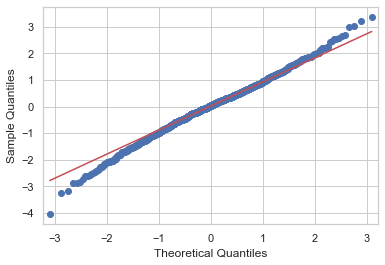

In [97]:
residuals = reg_model.resid 
sm.qqplot(residuals, fit=True, line="q")
plt.show()
# QQ plot suggests that residual distirubution is ok

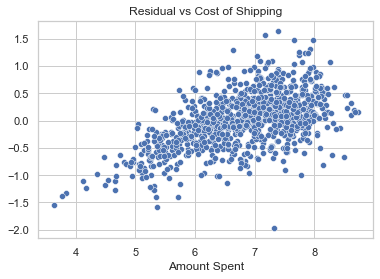

In [98]:
fig = sns.scatterplot(x=np.log(df_dummy["Amount Spent"]), y=residuals)
fig.set_title("Residual vs Cost of Shipping")
plt.show()

# Answers
    1) Fit a regression model with amount spent as target, and identify the relevant explanatory variables.
    Final regression model is :
    log(Amount Spent) = 5.5779 - 0.2453 * Children - 0.3948 * Close + 0.0411 * Catalogs + 1.961e-05 * Salary
    2) Which age groups spends the most on purchases? 
    On average, Age group 2 spends the most on purchase(average = 1,502), closely followed by Age group 3(average spend = 1,432) and least purchase is done by Age Group = 1(average spend = 559)
    3) How much additional spend is an extra catalog expected to generate?
    An extra catalog can increase the spend by a factor of 1.042, since we have taken log of target while modelling.
    4) What is the impact of no of children on amount spent. Does this make sense? Explain. 
    The coefficient for Children is -0.2453. This means that on average higher the number of children, the amount spend at  mall decreases. This makes sense:
        - People would like to save more, and consequently less spending on malls
        - People could also like more family time, which means less time at mall, and consequently less spending

In [112]:
np.exp(0.0411)

1.0419562959654682

In [113]:
np.exp(1)

2.718281828459045